In [2]:
# Necessary Library
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as npl
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

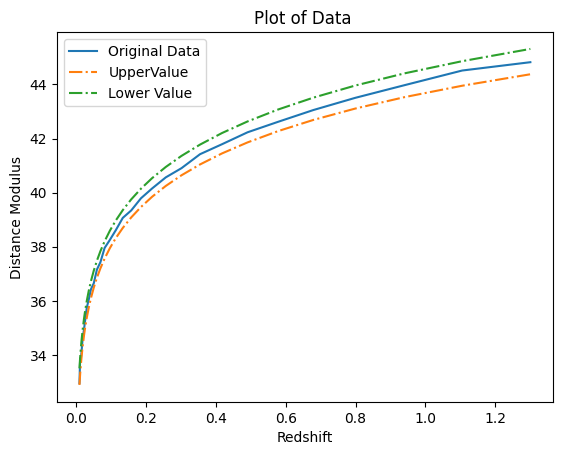

In [3]:

#Constants
c = 3*10**8
size = 31 
sample = 5000
par = 2
ar = np.empty([sample, par + 1])
#Path of both data file
cov_m = os.path.abspath("D:\\Chrome Download\\jla_mub_covmatrix.txt")      
data_f = os.path.abspath("D:\\Chrome Download\\jla_mub_0.txt")

#Open and load the data
Cov = open(cov_m,'r')
data = open(data_f,'r')
data_r = np.loadtxt(data)
Cov_matrix = np.loadtxt(Cov)

z = data_r[:,0]           #Redshift
M = data_r[:,1]
c  = np.reshape(Cov_matrix,(size,size))
inv_Cov = npl.inv(c)           #Inverse of the covariance matrix


#Defining the eta function
def eta(a,om_m):
    s = (1.0/om_m - 1.0)**(1.0/3.0)
    n = 2.0*np.sqrt(s**3.0+1.0)*(1/a**4.0 - 0.1540*s/a**3.0+0.4304*s**2.0/a**2.0+0.19097*s**3.0/a+0.066941*s**4.0)**(-1.0/8.0)
    return n

def D_L(z,om_m):
    D = (3000.0*(1+z))*(eta(1,om_m)-eta(1/(1+z),om_m))
    return D

def mu(z,om_m,h):
    m =  25-(5*np.log10(h))+(5*np.log10(D_L(z,om_m)))
    return  m



# Ploting the value
plt.plot(z,M,label='Original Data')   #Given data value
plt.plot(z,mu(z,0.4,0.8),linestyle = 'dashdot',label = 'UpperValue')   #some guessed value
plt.plot(z,mu(z,0.2,0.6),linestyle = 'dashdot',label = 'Lower Value')  #some guesses value
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Plot of Data ')
plt.legend();

    

Value of omega matter without prior : 0.29801961907029245
Value of h without prior : 0.7025863172755407
Value of acceptance ratio : 9.6
Value of omega matter with prior : 0.3009534447972252
Value of h with prior : 0.7021051007705502
Diffrence Between with and without prior in Omega : 0.0029338257269327372
Diffrence Between with and without prior in h : 0.0004812165049904449


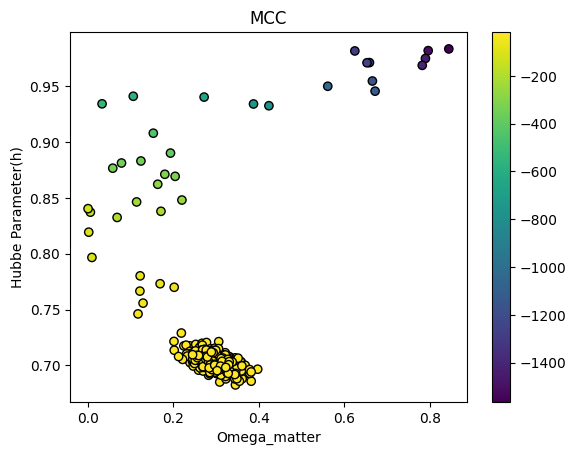

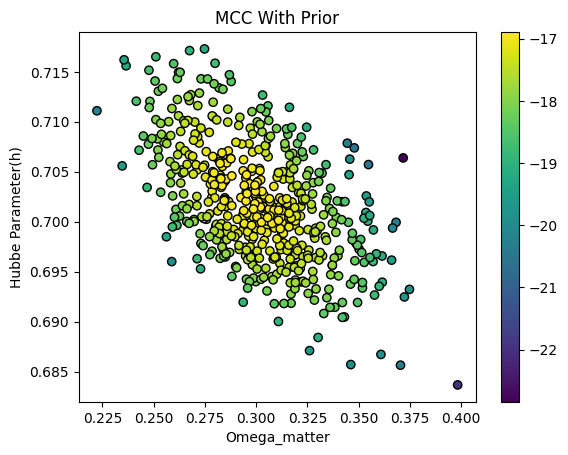

In [4]:
diff = np.empty(size) # diffrence of theoretical and observed values
std_om = 0.1
std_h = 0.01

# defining the likelihood value and correseponding  condition conditions
def likelihood(h,z,om_m,M):
    if om_m<= 0.0 or h <= 0.0 :
        L = -1.e100
    else:
        diff[:] = M - mu(z,om_m,h)
        dx = np.dot(inv_Cov,diff)
        L = -0.5*np.dot(diff,dx)         #Likelihood in log format
    return L



#MH-MCMC 
def MH_MCC(om_pro, h_pro):
    om_new = np.abs(om_pro + std_om*np.random.randn())
    h_new = np.abs(h_pro + std_h*np.random.randn())
# Likelihood becomes
    like_old = likelihood(h_pro,z,om_pro,M)
    like_new = likelihood(h_new,z,om_new,M)
    
    log_diff = like_new - like_old
    
    if np.log(np.random.normal(0.5,1.0)) < log_diff:
        return om_new,h_new ,True
    else:
        return om_pro,h_pro ,False


Omega = [1.0]    #Restoring the Estimated values
hubble = [1.0]
accept_rat = 0
ln_likelihood = []


for _ in range(1,sample):
    om_pro , h_pro = Omega[-1],hubble[-1]
    om_new , h_new, accepted = MH_MCC(om_pro,h_pro)
     
    if accepted:
        Omega.append(om_new)
        hubble.append(h_new)
        accept_rat += 1
        ln_likelihood.append(likelihood(h_new,z,om_new,M))

b = sample//20
Omega_mean = np.mean(Omega[b:])
hubble_mean = np.mean(hubble[b:])
Omega_std = np.std(Omega[b:])
hubble_std = np.std(hubble[b:])
accept_ratio = (accept_rat*100)/sample

mean_prior = 0.738
std_prior = 0.024
#Gaussian log prior
def prior_log(h):
    return - 0.5*((h - mean_prior)/ std_prior)**2 - np.log(std_prior*np.sqrt(2*np.pi))

def MH_MCC_PRIOR(om_pro, h_pro):
    om_new = np.abs(om_pro + std_om*np.random.randn())
    h_new = np.abs(h_pro + std_h*np.random.randn())

# Likelihood becomes
    like_old = likelihood(h_pro,z,om_pro,M)
    like_new = likelihood(h_new,z,om_new,M)
    
    
    like_old += prior_log(h_pro)
    like_new += prior_log(h_new)
    
    log_diff = like_new - like_old
    
    if np.log(np.random.normal(0.5,1.0)) < log_diff:
        return om_new,h_new ,True
    else:
        return om_pro,h_pro ,False

Omega_with_prior = [1.0]    #Restoring the Estimated values
hubble_with_prior = [1.0]
accept_rat_with_prior = 0
ln_likelihood_with_prior = []


for _ in range(1,sample):
    om_pro , h_pro = Omega[-1],hubble[-1]
    om_new , h_new, accepted = MH_MCC_PRIOR(om_pro,h_pro)
     
    if accepted:
        Omega_with_prior.append(om_new)
        hubble_with_prior.append(h_new)
        accept_rat_with_prior += 1
        ln_likelihood_with_prior.append(likelihood(h_new,z,om_new,M))

Omega_mean_prior = np.mean(Omega_with_prior[b:])
hubble_mean_prior = np.mean(hubble_with_prior[b:])

print('Value of omega matter without prior :', Omega_mean)
print('Value of h without prior :', hubble_mean)
print('Value of acceptance ratio :', accept_ratio)  

print('Value of omega matter with prior :', Omega_mean_prior)
print('Value of h with prior :', hubble_mean_prior)

print('Diffrence Between with and without prior in Omega :',np.abs(Omega_mean_prior - Omega_mean ))
print('Diffrence Between with and without prior in h :',np.abs(hubble_mean_prior - hubble_mean ))

plt.scatter(Omega[1:],hubble[1:], c = ln_likelihood,edgecolors='black' )
plt.colorbar()
plt.xlabel('Omega_matter')
plt.ylabel('Hubbe Parameter(h)')
plt.title('MCC')
plt.show()     
plt.scatter(Omega_with_prior[1:],hubble_with_prior[1:], c = ln_likelihood_with_prior,edgecolors='black')
plt.colorbar()
plt.xlabel('Omega_matter')
plt.ylabel('Hubbe Parameter(h)')
plt.title('MCC With Prior')
plt.show()
    

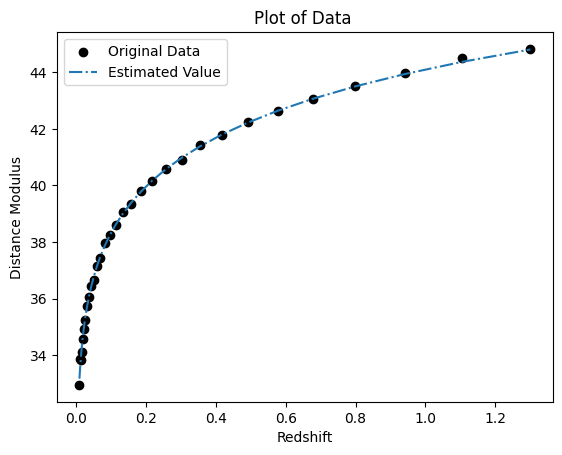

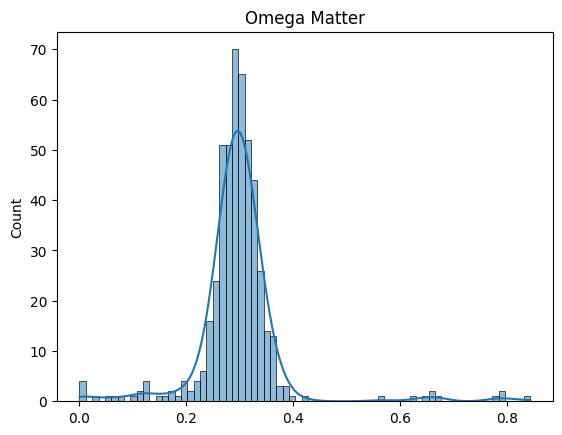

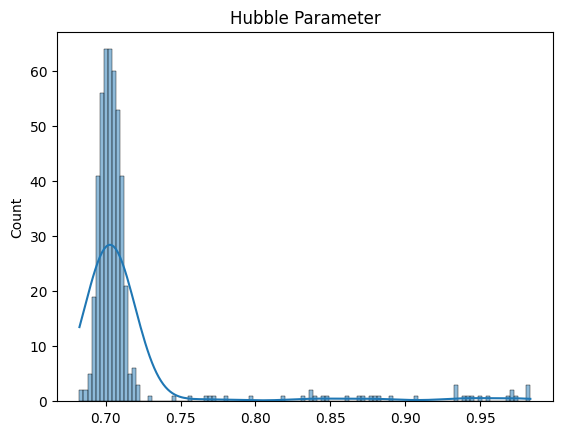

Covariance: 0.0009739220027787568
Variance Omega : 0.006503584434330107
Vairance Hubble : 0.002749568908834348


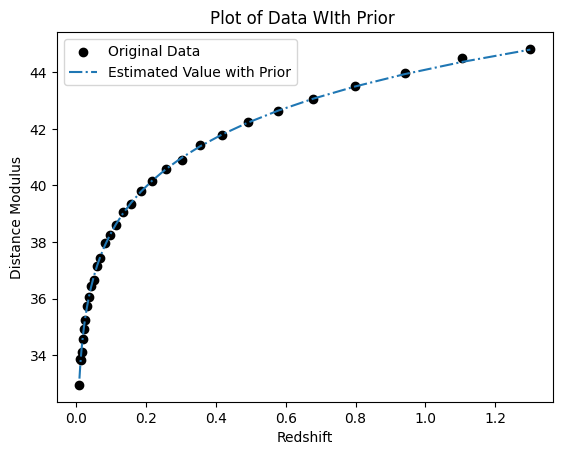

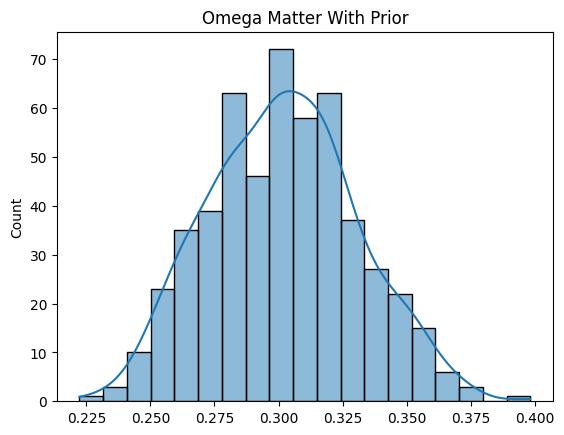

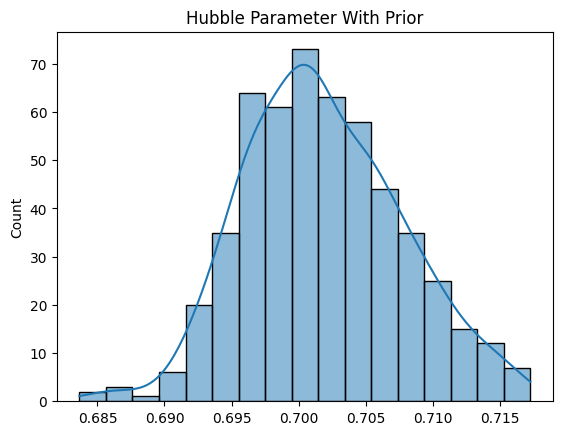

Covariance with Prior: -9.015097342760985e-05
Variance Omega with Prior : 0.0008298295777540504
Vairance Hubble with Prior : 3.441580870518862e-05


In [5]:
x_thero = np.empty(size)
for i in range(size):
    x_thero[i] = mu(z[i],Omega_mean,hubble_mean)

plt.scatter(z,M,label='Original Data',c = 'black')
plt.plot(z,x_thero,linestyle = 'dashdot',label = 'Estimated Value')
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Plot of Data ')
plt.legend();
plt.show(
)


sns.histplot(Omega[1:],kde=True)
plt.title('Omega Matter')
plt.show()



sns.histplot(hubble[1:],kde=True)
plt.title('Hubble Parameter')
plt.show()

# Covariance and variance 
variance_hubble = np.var(hubble[1:])
covar_omega = np.cov(Omega[1:],hubble[1:])[0,1]
variance_omega = np.var(Omega[1:])
print('Covariance:', covar_omega)
print('Variance Omega :', variance_omega)
print('Vairance Hubble :', variance_hubble)

x_thero_prior = np.empty(size)
for i in range(size):
    x_thero_prior[i] = mu(z[i],Omega_mean_prior,hubble_mean_prior)

plt.scatter(z,M,label='Original Data',c = 'black')
plt.plot(z,x_thero_prior,linestyle = 'dashdot',label = 'Estimated Value with Prior')

plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Plot of Data WIth Prior ')
plt.legend();
plt.show()


sns.histplot(Omega_with_prior[1:],kde=True)
plt.title('Omega Matter With Prior')
plt.show()



sns.histplot(hubble_with_prior[1:],kde=True)
plt.title('Hubble Parameter With Prior')
plt.show()

# Covariance and variance 
variance_hubble = np.var(hubble_with_prior[1:])
covar_omega = np.cov(Omega_with_prior[1:],hubble_with_prior[1:])[0,1]
variance_omega = np.var(Omega_with_prior[1:])
print('Covariance with Prior:', covar_omega)
print('Variance Omega with Prior :', variance_omega)
print('Vairance Hubble with Prior :', variance_hubble)



In [6]:
Chain_no = 5
om_new = []
h_new = []
Omega_ch = np.ones((Chain_no,sample))
hubble_ch = np.ones((Chain_no,sample))

for chain in range(Chain_no):
    Omega_chain = [1]
    hubble_chain = [1]
    
    for _ in range(1,sample):
        om_pro , h_pro = Omega[-1],hubble[-1]
        om_new , h_new, accepted = MH_MCC_PRIOR(om_pro,h_pro)
        
        if accepted:
            Omega_chain.append(om_new)
            hubble_chain.append(h_new)
    Omega_ch[chain,:len(Omega_chain) ] = Omega_chain
    hubble_ch[(chain),:len(hubble_chain)] = hubble_chain
    
    
    
def G_R(parameter):
    N, n = parameter.shape
    B_n = np.sum((np.mean(parameter,axis = 1) - np.mean(parameter))**2) / ( N - 1)
    w = np.mean(np.var(parameter,axis=1))
    Theta_var = (n - 1 ) /n * w + 1 /n *B_n
    R_stat = np.sqrt(Theta_var / w)
    return R_stat

Omega_GR = G_R(Omega_ch)
Hubble_GR = G_R(hubble_ch)
print('Gelman_rubin_convergence value for Omega matter:',Omega_GR)
print('Gelman_rubin_convergence value for Parameter h:',Hubble_GR)

Gelman_rubin_convergence value for Omega matter: 0.9999000415965693
Gelman_rubin_convergence value for Parameter h: 0.9999000393720475
